# UPM Epigentic Clock Example

For this demo I am using data 450k data pulled from GEO. [GSE41169](ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE41nnn/GSE41169/matrix/GSE41169_series_matrix.txt.gz) was deposited by Steve Horvath and includes age information for validation. 

## Library Import

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge
from scipy import optimize

In [6]:
# modify the system path and import the UPM code
import sys
sys.path.append('~/EpigeneticClock_UniversalPaceMaker')
from UPMRun import MethylationEM

## Open and Parse the Series Matrix File

In [8]:
# path set to local file 
series_matrix_files = 'GSE41169_series_matrix.txt'

In [9]:
ages = []
meth_matrix = []
meth_matrix_begin = False

count = 0

for line in open(series_matrix_files, 'r'):
    count += 1
    line_split = line.replace('\n', '').split('\t')
    if line_split[0] == '!Sample_characteristics_ch1':
        if 'age' in line_split[1]:
            for sample in line_split[1:]:
                age = float(sample.strip('"').split(' ')[1])
                ages.append(age)
    if meth_matrix_begin:
        meth_matrix.append(line_split)
    if line_split[0] == '!series_matrix_table_begin':
        meth_matrix_begin = True
print(ages)
print(count)

[32.0, 24.0, 65.0, 25.0, 32.0, 30.0, 21.0, 21.0, 21.0, 24.0, 24.0, 34.0, 36.0, 65.0, 49.0, 20.0, 29.0, 33.0, 24.0, 45.0, 32.0, 29.0, 35.0, 30.0, 47.0, 32.0, 36.0, 27.0, 23.0, 26.0, 38.0, 28.0, 30.0, 21.0, 26.0, 24.0, 34.0, 40.0, 37.0, 48.0, 31.0, 25.0, 63.0, 18.0, 32.0, 31.0, 33.0, 25.0, 20.0, 41.0, 28.0, 36.0, 45.0, 32.0, 25.0, 37.0, 46.0, 36.0, 52.0, 35.0, 39.0, 22.0, 32.0, 19.0, 23.0, 30.0, 40.0, 34.0, 29.0, 54.0, 36.0, 19.0, 52.0, 25.0, 50.0, 24.0, 27.0, 27.0, 20.0, 29.0, 26.0, 32.0, 25.0, 27.0, 20.0, 25.0, 24.0, 18.0, 20.0, 26.0, 27.0, 29.0, 29.0, 29.0, 23.0]
485650


## Get Methylation Dataframe Object
- Selecting sites using ridge regression

In [10]:
meth_df = pd.DataFrame(data=meth_matrix[1:-1])
meth_df.columns = meth_matrix[0]
meth_df = meth_df.set_index('"ID_REF"')
meth_df = meth_df.apply(pd.to_numeric)
meth_df = meth_df.dropna(axis=0)

In [33]:
ridge_default_params = {'alpha':1.0, 'fit_intercept':True, 'normalize':False, 'copy_X':True, 'max_iter':100, 'tol':0.0001, 'solver':'auto', 'random_state':None}

In [41]:
ridge_sites = []

ridge = Ridge(**ridge_default_params)
ridge.fit(meth_df.T.values, ages)
for site, coef in zip(meth_df.index, ridge.coef_):
    if coef > 0.05:
        ridge_sites.append(site)

In [42]:
len(ridge_sites)

137

In [43]:
# keep only ridge sites and drop other to clear memory
meth_df = meth_df.loc[ridge_sites]

### Biomarker Implementation

In [44]:
# fit model 
age_em = MethylationEM(methylation_table=meth_df.values.tolist(),
                        sample_list=list(meth_df),
                        site_list=list(meth_df.index),
                        times=ages,
                        iter_limit=100,
                        err_tolerance=0.00001)

In [48]:
pace_maker_ages = age_em.UPM_EC_EM_results['PM_times']

In [51]:
# define a function to fit the UPM age to chronological age trend line
def func(x, a, b, c):
    return a * np.log(x) + c

In [52]:
# scipy curve fitting
popt, pcov = optimize.curve_fit(func, ages, pace_maker_ages)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/optimize/minpack.py:785: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


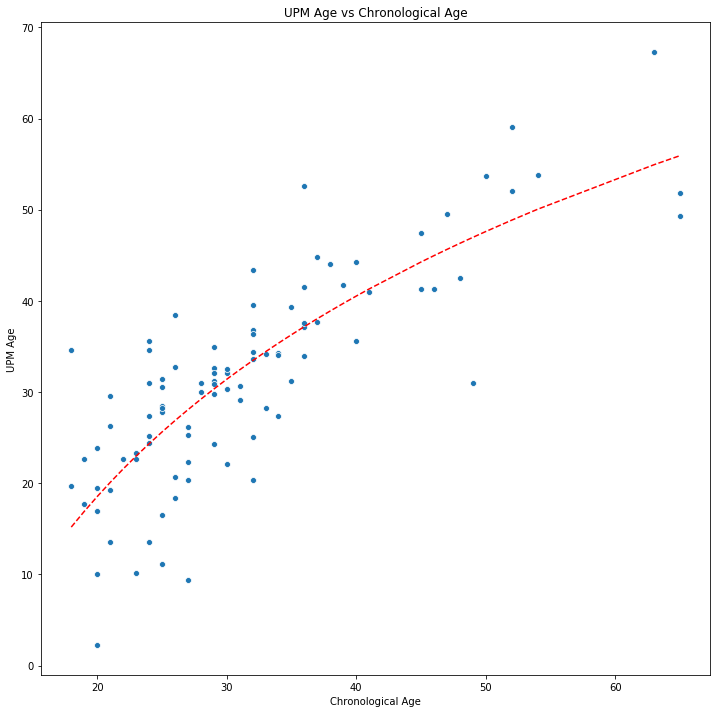

In [57]:
fig, ax = plt.subplots(figsize=(12,12))
plt.title('UPM Age vs Chronological Age')
sns.scatterplot(x=ages, y=pace_maker_ages, ax=ax)
plt.plot(sorted(ages), func(sorted(ages), *popt), 'r--', label="Fitted Curve")
plt.xlabel('Chronological Age')
plt.ylabel('UPM Age')
plt.savefig('UPM_Example', dpi=300)
plt.show()